# Notebook Setup and Package Installation

In this section, we install the required packages.

In [1]:
!pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U peft

  Cloning https://github.com/huggingface/transformers (to revision v4.49.0-Gemma-3) to /tmp/pip-req-build-e4y7f_ek
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-e4y7f_ek
  Running command git checkout -q 1c0f782fe5f983727ff245c4c1b3906f9b99eec2
  Resolved https://github.com/huggingface/transformers to commit 1c0f782fe5f983727ff245c4c1b3906f9b99eec2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Environment Setup and Imports

Set environment variables and import necessary libraries.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["WANDB_DISABLED"] = "true" 
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer, SFTConfig
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

# Disable specific GPU memory optimizations
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


working on cuda:0


# Data Loading and Preprocessing

Load the CSV data, set proper column names, and create train, test, and evaluation splits.


In [4]:
filename = "/kaggle/input/financial-sentiment-analysis/data.csv"

df = pd.read_csv(filename, encoding="utf-8", encoding_errors="replace")
df.columns = ["text", "sentiment"]

# Sample from each sentiment class for train and test sets
X_train = list()
X_test = list()
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment == sentiment],
                                    train_size=300,
                                    test_size=300,
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval.groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))

X_train = X_train.reset_index(drop=True)
print(X_train.shape, X_eval.shape, X_test.shape)


(900, 2) (150, 2) (900, 2)


# Prompt Generation Functions

Define functions to generate prompts for training and testing.


In [5]:
def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = """.strip()


# Dataset Conversion

Convert the pandas DataFrames into Hugging Face Dataset objects.


In [6]:
# Prepare DataFrames with prompts
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), columns=["text"])

# Extract true labels for testing
y_true = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

# Convert to Dataset objects
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)


# Evaluation Function

Define a function to evaluate predictions by computing accuracy, classification report, and confusion matrix.


In [7]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none': 1, 'negative': 0}
    
    def map_func(x):
        return mapping.get(x, 1)
    
    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Calculate overall accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Per-label accuracy
    class_labels = ['negative', 'neutral', 'positive']
    unique_labels = set(y_true)
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label `{class_labels[label]}`: {label_accuracy:.3f}')

    # Classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred, target_names=class_labels)
    print('\nClassification Report:')
    print(class_report)

    # Confusion matrix and heatmap
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


# Testing Gemma2 Model Without Fine-Tuning

Load the Gemma2 model, define the prediction function, and evaluate its performance before fine-tuning.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
100%|██████████| 900/900 [01:31<00:00,  9.84it/s]


Accuracy: 0.399
Accuracy for label `negative`: 0.497
Accuracy for label `neutral`: 0.593
Accuracy for label `positive`: 0.107

Classification Report:
              precision    recall  f1-score   support

    negative       0.49      0.50      0.49       300
     neutral       0.32      0.59      0.42       300
    positive       0.76      0.11      0.19       300

    accuracy                           0.40       900
   macro avg       0.52      0.40      0.37       900
weighted avg       0.52      0.40      0.37       900


Confusion Matrix:
[[149 151   0]
 [112 178  10]
 [ 44 224  32]]


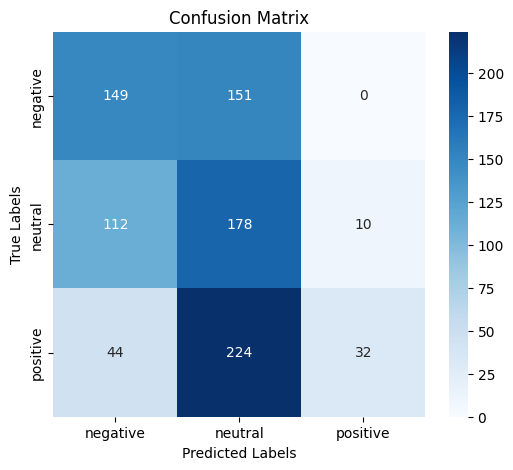

In [8]:
model_name = "/kaggle/input/gemma-2/transformers/gemma-2-2b/2"
compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype=compute_dtype,
    quantization_config=bnb_config,
)
model.config.use_cache = False
model.config.pretraining_tp = 1

max_seq_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)
tokenizer.pad_token_id = tokenizer.eos_token_id

def predict(test, predictor_model, tokenizer):
    y_pred = []
    pipe = pipeline(task="text-generation",
                    model=predictor_model,
                    tokenizer=tokenizer,
                    max_new_tokens=1,
                    temperature=0.0)
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1]
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

# Predict sentiment using Gemma2 without fine-tuning
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)


# Fine-Tuning the Gemma2 Model

Define the PEFT configuration, training arguments, and fine-tune the Gemma2 model.


In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import EarlyStoppingCallback, IntervalStrategy

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

output_dir = "trained_weigths"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
)

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=10,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    lr_scheduler_type="cosine",
    report_to="none",
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    args=SFTConfig(
         dataset_text_field="text",
         max_seq_length=max_seq_length,
         packing=False,
         output_dir="output_dir",
         dataset_kwargs={
             "add_special_tokens": False,
             "append_concat_token": False,
         },
    ),
)

# Remove WandB callback if added
from transformers.integrations import WandbCallback
trainer.callback_handler.remove_callback(WandbCallback)

# Train the model
trainer.train()

# Save the fine-tuned model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Converting train dataset to ChatML:   0%|          | 0/900 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/150 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
It is strongly recommended to train Gemma2 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss


('trained_weigths/tokenizer_config.json',
 'trained_weigths/special_tokens_map.json',
 'trained_weigths/tokenizer.model',
 'trained_weigths/added_tokens.json',
 'trained_weigths/tokenizer.json')

# Testing the Fine-Tuned Gemma2 Model

Load the fine-tuned model and evaluate its performance.


Let's see what is the classification report for the evaluation set.

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
100%|██████████| 900/900 [01:56<00:00,  7.76it/s]


Accuracy: 0.780
Accuracy for label `negative`: 0.920
Accuracy for label `neutral`: 0.610
Accuracy for label `positive`: 0.810

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.92      0.86       300
     neutral       0.75      0.61      0.67       300
    positive       0.78      0.81      0.80       300

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.77       900
weighted avg       0.78      0.78      0.77       900


Confusion Matrix:
[[276  17   7]
 [ 56 183  61]
 [ 12  45 243]]


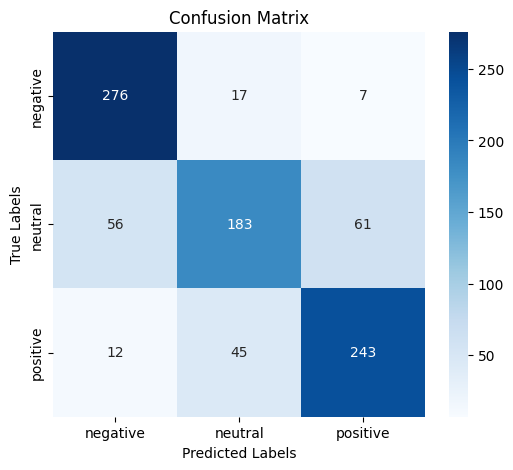

In [10]:
trained_model_name = "/kaggle/working/output_dir/checkpoint-339"
trained_model = AutoModelForCausalLM.from_pretrained(
    trained_model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config,
)
trained_model.config.use_cache = False
trained_model.config.pretraining_tp = 1

y_trained_pred = predict(X_test, trained_model, tokenizer)
evaluate(y_true, y_trained_pred)


# Fine-Tuning and Testing the Gemma3 Model

Load the Gemma3 model, evaluate before fine-tuning, perform fine-tuning, and evaluate after.


Device set to use cuda:0
100%|██████████| 900/900 [01:45<00:00,  8.51it/s]


Gemma 3 Before Fine-tuning:
Accuracy: 0.327
Accuracy for label `negative`: 0.003
Accuracy for label `neutral`: 0.900
Accuracy for label `positive`: 0.077

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.00      0.01       300
     neutral       0.32      0.90      0.47       300
    positive       0.37      0.08      0.13       300

    accuracy                           0.33       900
   macro avg       0.56      0.33      0.20       900
weighted avg       0.56      0.33      0.20       900


Confusion Matrix:
[[  1 290   9]
 [  0 270  30]
 [  0 277  23]]


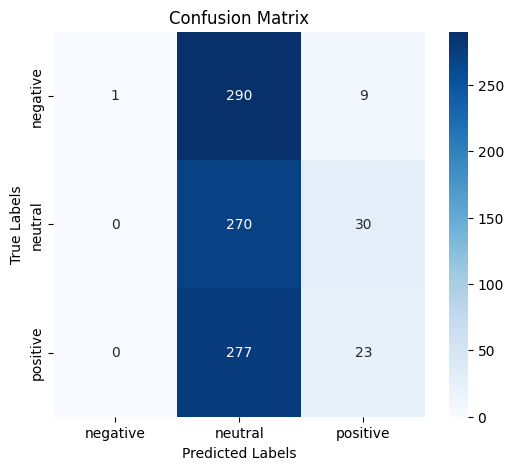

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Converting train dataset to ChatML:   0%|          | 0/900 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/150 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
It is strongly recommended to train Gemma3 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss


Device set to use cuda:0
100%|██████████| 900/900 [02:04<00:00,  7.22it/s]


Gemma 3 After Fine-tuning:
Accuracy: 0.772
Accuracy for label `negative`: 0.840
Accuracy for label `neutral`: 0.693
Accuracy for label `positive`: 0.783

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.84      0.82       300
     neutral       0.73      0.69      0.71       300
    positive       0.78      0.78      0.78       300

    accuracy                           0.77       900
   macro avg       0.77      0.77      0.77       900
weighted avg       0.77      0.77      0.77       900


Confusion Matrix:
[[252  32  16]
 [ 43 208  49]
 [ 21  44 235]]


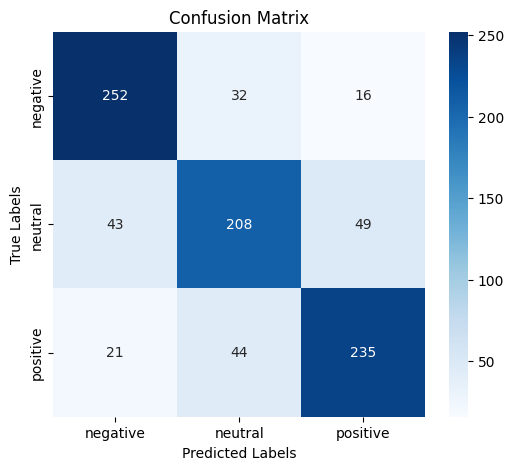

In [11]:
from transformers import AutoTokenizer, Gemma3ForCausalLM

gemma3_model_name = "/kaggle/input/gemma-3/transformers/gemma-3-1b-it/1"
compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

gemma3_model = AutoModelForCausalLM.from_pretrained(
    gemma3_model_name,
    device_map='auto',
    torch_dtype=compute_dtype,
    quantization_config=bnb_config,
)

gemma3_model.config.use_cache = False
gemma3_model.config.pretraining_tp = 1

max_seq_length = 512
gemma3_tokenizer = AutoTokenizer.from_pretrained(gemma3_model_name, max_seq_length=max_seq_length)
gemma3_tokenizer.pad_token_id = tokenizer.eos_token_id

# Prediction before fine-tuning Gemma3
y_gemma3_pred = predict(X_test, gemma3_model, gemma3_tokenizer)
print("Gemma 3 Before Fine-tuning:")
evaluate(y_true, y_gemma3_pred)

# Fine-tuning Gemma3
gemma3_output_dir = "gemma3_trained_weights"
gemma3_trainer = SFTTrainer(
    model=gemma3_model,
    tokenizer=gemma3_tokenizer,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    args=SFTConfig(
         dataset_text_field="text",
         max_seq_length=max_seq_length,
         packing=False,
         output_dir=gemma3_output_dir,
         dataset_kwargs={
             "add_special_tokens": False,
             "append_concat_token": False,
         },
    ),
)

# Remove WandB callback if present
gemma3_trainer.callback_handler.remove_callback(WandbCallback)

gemma3_trainer.train()
gemma3_trainer.save_model()
gemma3_tokenizer.save_pretrained(gemma3_output_dir)

gemma3_trained_model_name = f"{gemma3_output_dir}/checkpoint-339"
gemma3_trained_model = AutoModelForCausalLM.from_pretrained(
    gemma3_trained_model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config,
)
gemma3_trained_model.config.use_cache = False
gemma3_trained_model.config.pretraining_tp = 1

# Prediction after fine-tuning Gemma3
y_gemma3_trained_pred = predict(X_test, gemma3_trained_model, gemma3_tokenizer)
print("Gemma 3 After Fine-tuning:")
evaluate(y_true, y_gemma3_trained_pred)


# Comparative Analysis

Compare the accuracy before and after fine-tuning for both Gemma2 and Gemma3.


In [12]:
from sklearn.metrics import accuracy_score

accuracy_gemma2_before = accuracy_score(y_true, y_pred)
accuracy_gemma2_after  = accuracy_score(y_true, y_trained_pred)
accuracy_gemma3_before = accuracy_score(y_true, y_gemma3_pred)
accuracy_gemma3_after  = accuracy_score(y_true, y_gemma3_trained_pred)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Model": ["Gemma 2", "Gemma 2", "Gemma 3", "Gemma 3"],
    "Stage": ["Before Fine-tuning", "After Fine-tuning", "Before Fine-tuning", "After Fine-tuning"],
    "Accuracy": [accuracy_gemma2_before, accuracy_gemma2_after, accuracy_gemma3_before, accuracy_gemma3_after]
})

print("Comparative Analysis of Gemma 2 vs Gemma 3:")
display(comparison_df)


Comparative Analysis of Gemma 2 vs Gemma 3:


,Model,Stage,Accuracy
0,Gemma 2,Before Fine-tuning,0.201111
1,Gemma 2,After Fine-tuning,0.780000
2,Gemma 3,Before Fine-tuning,0.026667
3,Gemma 3,After Fine-tuning,0.771111


# Additional Analysis: Detailed Metrics and Visualizations

The following code computes detailed classification reports (precision, recall, and F1-score) for both Gemma2 and Gemma3 before and after fine-tuning. It then plots these metrics in a grouped bar chart along with a simple bar chart comparing overall accuracies. This additional analysis helps us better understand model performance nuances and the impact of fine-tuning.


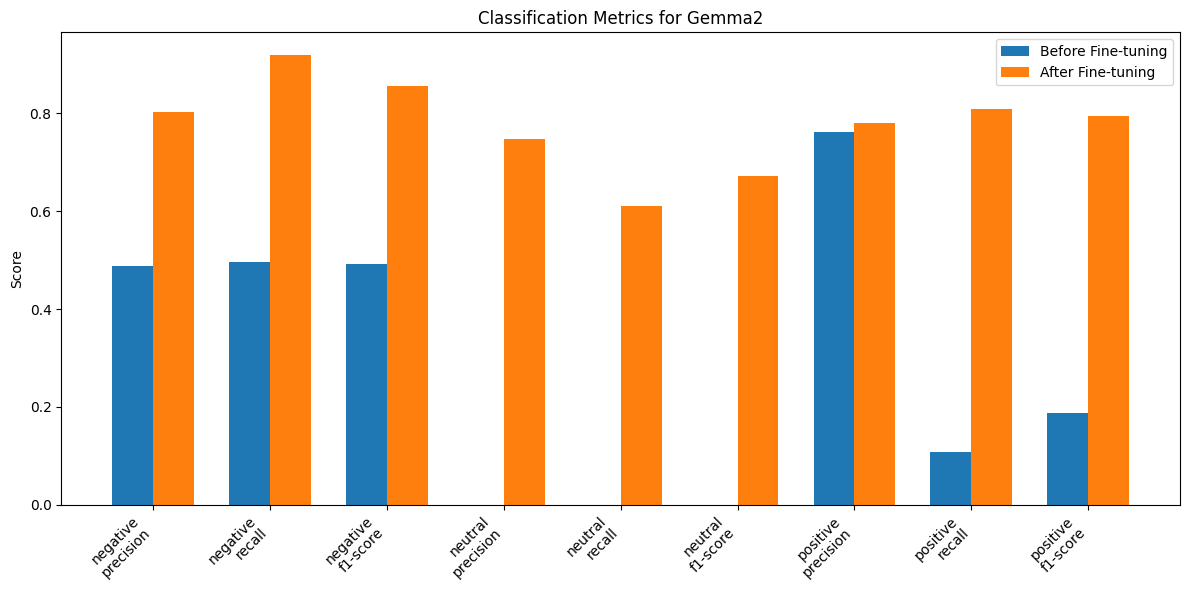

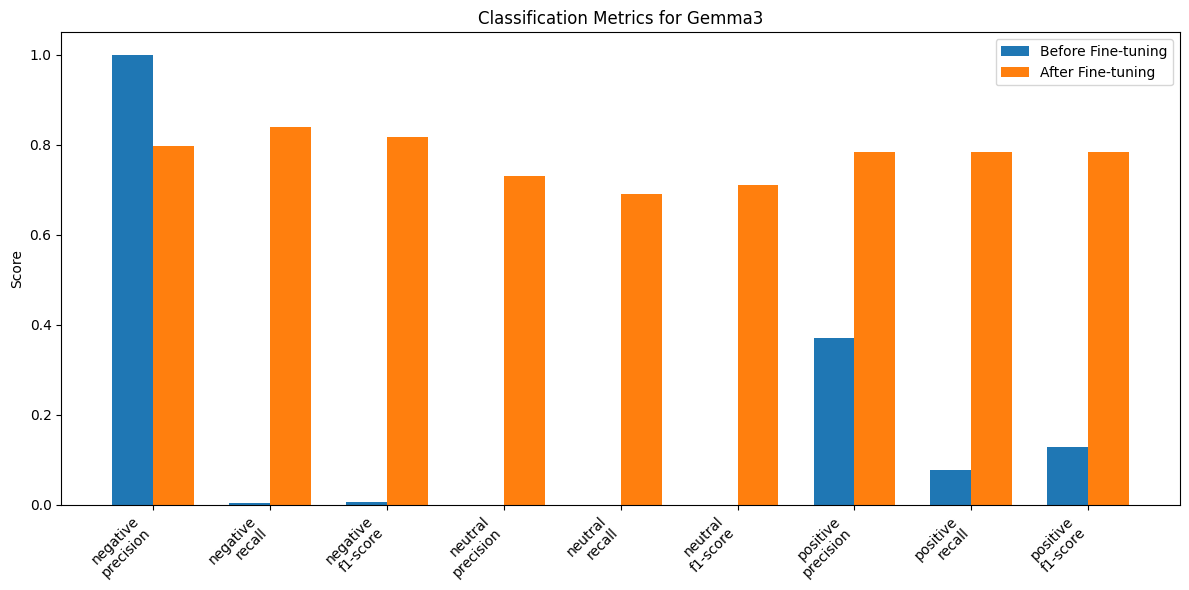

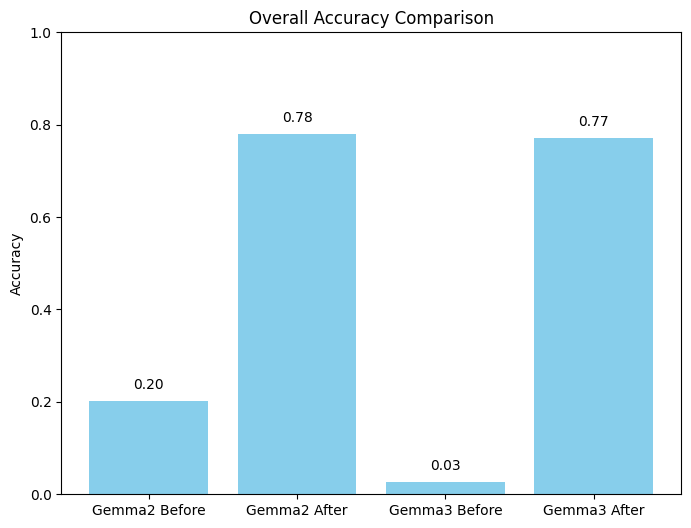

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Compute classification reports for each model stage
report_gemma2_before = classification_report(y_true, y_pred, output_dict=True, labels=['negative', 'neutral', 'positive'])
report_gemma2_after = classification_report(y_true, y_trained_pred, output_dict=True, labels=['negative', 'neutral', 'positive'])
report_gemma3_before = classification_report(y_true, y_gemma3_pred, output_dict=True, labels=['negative', 'neutral', 'positive'])
report_gemma3_after = classification_report(y_true, y_gemma3_trained_pred, output_dict=True, labels=['negative', 'neutral', 'positive'])

def plot_classification_metrics(report_before, report_after, model_name):
    metrics = ['precision', 'recall', 'f1-score']
    classes = ['negative', 'neutral', 'positive']
    
    # Prepare data for plotting
    x_labels = []
    before_vals = []
    after_vals = []
    for cls in classes:
        for metric in metrics:
            x_labels.append(f"{cls}\n{metric}")
            before_vals.append(report_before[cls][metric])
            after_vals.append(report_after[cls][metric])
    
    x = np.arange(len(x_labels))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, before_vals, width, label='Before Fine-tuning')
    plt.bar(x + width/2, after_vals, width, label='After Fine-tuning')
    plt.xticks(x, x_labels, rotation=45, ha='right')
    plt.ylabel('Score')
    plt.title(f'Classification Metrics for {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot metrics for Gemma2 and Gemma3
plot_classification_metrics(report_gemma2_before, report_gemma2_after, "Gemma2")
plot_classification_metrics(report_gemma3_before, report_gemma3_after, "Gemma3")

# Plot overall accuracy comparison
models = ['Gemma2', 'Gemma2', 'Gemma3', 'Gemma3']
stages = ['Before', 'After', 'Before', 'After']
accuracies = [accuracy_gemma2_before, accuracy_gemma2_after, accuracy_gemma3_before, accuracy_gemma3_after]

plt.figure(figsize=(8, 6))
bars = plt.bar([f"{m} {s}" for m, s in zip(models, stages)], accuracies, color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Overall Accuracy Comparison")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')
plt.show()
